## Week6

In this part, we'll load a pre-trained network and play with it.

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import cPickle as pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5105)


# Model Zoo (4 pts)
Lasagne has a plethora of pre-training netrworks in the [model zoo](https://github.com/Lasagne/Recipes/tree/master/modelzoo)
* Even more models within the community (neighbor repos, PRs, etc.)


We'll start by picking VGG16 and deploying it in our notebook.

__Warning!__ VGG16 network requires around 3GB of memory to predict event for single-image batch. If you don't have that luxury, try [binder](http://mybinder.org/repo/yandexdataschool/practical_rl) or [azure notebooks](http://notebooks.azure.com/).


In [2]:
#!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl -O weights.pkl

--2017-03-22 16:21:02--  https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.18.11
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.18.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553459517 (528M) [binary/octet-stream]
Saving to: 'weights.pkl'

100%[======================================>] 553,459,517 22.5MB/s   in 25s    

2017-03-22 16:21:27 (21.4 MB/s) - 'weights.pkl' saved [553459517/553459517]



In [3]:
# copyright: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/


from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [4]:
#classes' names are stored here
classes = pickle.load(open('classes.pkl'))
#for example, 10th class is ostrich:
print classes[9]

ostrich, Struthio camelus


You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, our net won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [5]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img = img[:,:,::-1]

    img = img - MEAN_VALUES
    
    #convert from [w,h,3 to 1,3,w,h]
    img = np.transpose(img, (2, 0, 1))[None]
    return img.astype("float32")

def deprocess(img):
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    for i in xrange(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print np.linalg.norm(deprocess(preprocess(img)) - img)

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [6]:
net = build_model()

In [7]:
import pickle
with open('weights.pkl') as f:
    weights = pickle.load(f)
    
# <load weights into the network>

In [8]:
lasagne.layers.set_all_param_values(net["prob"], weights["param values"])

In [9]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net["prob"],
                                   input_image,
                                   deterministic=True)

prob = theano.function([input_image], output) 

### Sanity check
Let's make sure our network actually works. 

To do so, we'll feed it with some example images.

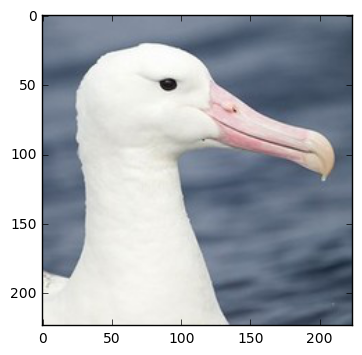

top-5 classes are:
0.996280	albatross
0.003715	goose
0.000001	drake
0.000001	white stork
0.000001	spoonbill


In [10]:
img = imread('sample_images/albatross.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print 'top-5 classes are:'
for l in labels:
    print '%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0])

##### Ouch!
Try running network 2-3 times. If output changes, then we've probably done something wrong.

Figure out, what's the problem with the network.

_hint_ there are two such 'problematic' layers in vgg16. They're all near the end.

You can make network deterministic by giving it such flag in the `lasagne.layers.get_output` function above.

#### Fun opportunity

ImageNet does not contain any human classes, so if you feed the network with some human photo, it will most likely hallucinate something which is closest to your image.

Try feeding the network with something peculiar: your avatar, Donald Trump, Victor Lempitsky or anyone.

# Grand-quest: Dogs Vs Cats (6 pts)
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [11]:
#!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
#!unzip data.zip
#you may need to adjust paths in the next section, depending on your OS

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [12]:
def get_features(img):
    return prob(img)

In [13]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imresize
import os
X = []
Y = []

#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))
    features = get_features(img)
    Y.append(y)
    X.append(features)

100%|██████████| 25000/25000 [14:56<00:00, 27.87it/s]


In [58]:
"catolp".startswith("cat")

True

In [14]:

X = np.concatenate(X) #stack all [1xfeature] matrices into one. 
assert X.ndim==2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = Y[:len(X)]

In [15]:
from sklearn.cross_validation import train_test_split



/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)

In [74]:
clf = RandomForestClassifier(n_estimators=100, max_depth=None,
    min_samples_split=2, random_state=0, verbose=True)
#scores = cross_val_score(clf, X, Y)

#scores.mean() 

In [75]:
clf.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   51.7s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=True, warm_start=False)

In [76]:
clf.score(X_test, y_test)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


0.98072727272727278

In [78]:
clf.predict_proba(Xtest[0])

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


array([[ 0.01,  0.99]])

In [64]:
/home/ubuntu/YSDA_deeplearning17/Seminar5/answer.csv

/home/ubuntu/YSDA_deeplearning17/Seminar5


In [65]:
file_test = 'id,label\n'
for i in enumerate(Xtest, 1):
    predict = clf.predict_proba(i[1])[0][0]
    file_test += "{},{}\n".format(i[0], predict)
    # print "{},{}\n".format(i[0], 1-predict)
    
file = open("answer.csv","w") 
file.write(file_test)
file.close() 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

In [49]:
list(enumerate(Xtest[:10], 1))[5]

(6, array([[  1.46188188e-06,   7.16199293e-06,   3.29194904e-06,
           1.34440563e-06,   4.07748121e-06,   1.21479334e-05,
           4.07018524e-06,   1.26258783e-05,   1.99140140e-05,
           1.06470577e-06,   1.00629018e-06,   1.49405389e-06,
           2.84554199e-06,   1.62753304e-06,   7.68016207e-07,
           1.04540868e-06,   4.67200095e-07,   1.65095878e-06,
           7.42367661e-07,   1.61847356e-06,   4.18258622e-07,
           1.48858828e-06,   1.12025668e-06,   1.64341236e-06,
           9.21764354e-07,   1.24925054e-06,   2.06201253e-06,
           2.56176349e-06,   7.78426511e-07,   5.71135115e-06,
           2.25279155e-06,   7.39954976e-06,   5.71188502e-06,
           2.90004264e-05,   5.48254138e-06,   1.56497424e-06,
           2.44995476e-06,   2.48043034e-06,   4.05581386e-06,
           4.45735941e-06,   1.81887651e-06,   1.04221829e-06,
           1.87001456e-06,   8.25241750e-06,   6.83441499e-07,
           1.59548915e-06,   1.79566757e-06,   2.203

In [25]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imresize
import os
Xpredict = []

#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('/home/ubuntu/test/')):
    img = imread("/home/ubuntu/test/"+fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))
    features = get_features(img)
    Xpredict.append(features)

100%|██████████| 12500/12500 [07:25<00:00, 28.03it/s]


# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `lasagne.updates.mysupermegaoptimizer(loss, only_those_weights_i_wanna_train)`
  * selecting all weights from the head but not below the neck:
      * `all_params = lasagne.layers.get_all_params(new_output_layer_or_layers,trainable=True)`
      * `old_params= lasagne.layers.get_all_params(neck_layers,trainable=True)`
      * `new_params = [w for w in all_params if w not in old_params]`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * since updates are dictionaries, one can just compute union
      * `updates = {}`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * make sure they do not have overlapping keys. Otherwise, earlier one will be forgotten.
      * `assert len(updates) == len(old_updates) + len(new_updates)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats
      * get test data https://www.kaggle.com/c/dogs-vs-cats/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [ ]:
print "I can do it!"